In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import *
from cmath import phase
from numpy import array
from scipy.sparse import csr_matrix
import urllib
import glob
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from random import randint

#!wget https://github.com/MelanieTschiersch/SmithData/blob/main/Sa191226.mat?raw=true # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat

#!wget https://github.com/comptelab/distributedWM/blob/main/smith/PFC_PFC/Sa191202.mat # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat
data={'Sa': [], 'Pe':[], 'Wa':[]}
for m in ["Sa", "Pe", "Wa"]:
    files = np.sort(glob.glob('../Data/%s*.mat' %m))
    for f in files:
#data = loadmat('distributedWM/smith/PFC_PFC/Sa191202.mat')#Sa191203
        data[m].append(loadmat(f))
        print(f)
    #files_web = np.sort(glob.glob('%s*.mat' %m))
    #for f in files_web:
    #    data[m].append(loadmat(f))#, Pe180728.mat, Wa180222.mat, Sa191226.mat


../Data/Sa191202.mat
../Data/Sa191203.mat
../Data/Sa191226.mat
../Data/Pe180728.mat
../Data/Wa180222.mat


In [70]:
# circstats
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return nan
    
def circdist(angles1,angles2):
    ''' calculates circular distance of angles [rad]'''
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

In [131]:
def convert_cm2deg(x, y):
    '''
    Converts angles of visual degree to angles on WM circle

    Parameters
    ----------
    x : list of array of x-positions in deg for all sessions 
    y : list of array of y-positions in deg for all sessions

    Returns
    -------
    alpha_full: list of arrays of Angle on working-memory circle in [°] 

    '''

    alpha_full = np.zeros(len(x))
       
    # tangens only goes from 0-180, change to 0-360
    idx = np.where(np.logical_and(x>0, y>0))# for x,y>0
    alpha_full[idx] = [np.arctan((y[k]*np.pi/180)/(x[k]*np.pi/180)) for k in idx]

    idx = np.where(np.logical_or(np.logical_and(x<0, y>0), np.logical_and(x<0, y<0)))# for x,y>0
    alpha_full[idx] = [np.pi+np.arctan((y[k]*np.pi/180)/(x[k]*np.pi/180)) for k in idx]
    
    idx = np.where(np.logical_and(x>0, y<0))
    alpha_full[idx] = [2*np.pi+np.arctan((y[k]*np.pi/180)/(x[k]*np.pi/180)) for k in idx]
    return [i*180/np.pi for i in alpha_full]

In [118]:
def calc_errorcurve(results):
    '''
    Calculates single-sided serial dependence curve

    Parameters
    ----------
    results :   monkey data for [subject][params], with params:
                            target1:   target shown in previous trial
                            target2:   target shown in current trial
                            response1: response given in previous trial
                            response2: response given in current trial
                results : {"a": {"target1": [],"target2": [],"response1": [],"response2": []}, 
                           "l": {"target1": [],"target2": [],"response1": [],"response2": []}}
                w1      : smoothing window width
                w2      : smoothing window shift

    Returns
    -------
    err_avg : average smoothed error per monkey 
    rel_loc_avg : relative location equally spaced in [0,pi]
    err_std : sem of smoothed error
    err : original (unsmoothed) flipped error to (0,pi)

    '''
    rel_loc=[]
    err = []
    rel_loc.append(circdist(results['target_curr'],results['target_prev']))# relative location current prvious stimulus
    err.append(circdist(results['target_curr'],results['response_curr']))# error current trial
    # create half curve
    err = np.squeeze(err)#np.squeeze(np.sign(rel_loc)*err)# flip error along x-axis
    rel_loc = np.squeeze(np.round(rel_loc,3))#np.squeeze(np.sign(rel_loc)*rel_loc)# flip location along y-axis
    return rel_loc, err


In [119]:
left_idx = {'Sa': [[] for i in range(len(data['Sa']))], 'Pe':[[] for i in range(len(data['Pe']))], 'Wa':[[] for i in range(len(data['Wa']))]}
right_idx = {'Sa': [[] for i in range(len(data['Sa']))], 'Pe':[[] for i in range(len(data['Pe']))], 'Wa':[[] for i in range(len(data['Wa']))]}
for m in ["Sa", "Pe", "Wa"]:
    for n in range(len(data[m])):
        left_idx[m][n] = data[m][n]['left_idx']
        right_idx[m][n] = data[m][n]['right_idx']


In [120]:
dataset=[]
monkey=[]
session=[]
for m in ['Sa','Pe','Wa']:
    for n in range(len(data[m])):
        for line in data[m][n]['dat'][0]:
            dataset.append([row if not isinstance(row, np.ndarray) else row.flat[0] if len(row[0])==1 else row[0] for row in line])
            monkey.append(m)
            session.append(n)


columns = ['trial_id','sp_train', 'outcome', 'timing', 'targ_xy', 'targ_angle', 'saccade_xy', 'saccade_angle']

df_dat = pd.DataFrame(dataset, columns=columns)
df_dat['monkey'] = monkey
df_dat['session'] = session

In [121]:
taskperiods = ['fix', 'targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
for i in range(len(taskperiods)):
    df_dat[taskperiods[i]] = [line[i].flat[0] for line in df_dat['timing']]
del df_dat['timing']

In [122]:
clockw=[]
hemifield = []#["" for x in range(len(df_dat['targ_on']))]
for n in range(len(df_dat['targ_on'])):
    # determine hemifield
    if (df_dat['targ_angle'][n]<90) | (df_dat['targ_angle'][n]>270):
        hemifield.append("r")# right hemifield
    else:
        hemifield.append("l")# left hemifield
    # determine clockwise/counterclockwise responses relative to target 
    if circdist(df_dat['targ_angle'][n]*np.pi/180, df_dat['saccade_angle'][n]*np.pi/180)<=0:
        clockw.append('CW') 
    else:
        clockw.append('CCW') 

df_dat['clockw'] = clockw
df_dat['hemifield'] = hemifield
df_dat.head()

,trial_id,sp_train,outcome,targ_xy,targ_angle,saccade_xy,saccade_angle,monkey,session,fix,targ_on,targ_off,go_cue,saccade,reward,clockw,hemifield
0,1,"(40, 0)\t1.0\n (73, 0)\t1.0\n (51, 1)\t1.0...",CORRECT,"[-81.32022937758153, -196.32440065864844]",247.5,"[-94.13180712732776, -171.71289550644755]",241.268755,Sa,0,1,236,656,3706,3904,4036,CCW,l
1,2,"(35, 1)\t1.0\n (7, 2)\t1.0\n (12, 2)\t1.0\...",CORRECT,"[196.32440065864844, -81.32022937758153]",337.5,"[181.59180019708026, -74.49810902444511]",337.694090,Sa,0,1,239,659,2189,2391,2519,CW,r
2,4,"(21, 0)\t1.0\n (68, 0)\t1.0\n (87, 0)\t1.0...",CORRECT,"[-81.32022937758157, 196.32440065864844]",112.5,"[-96.76686414165835, 177.17716528930353]",118.641548,Sa,0,1,239,659,2789,2983,3109,CW,l
3,5,"(6, 0)\t1.0\n (61, 0)\t1.0\n (71, 0)\t1.0\...",CORRECT,"[-196.32440065864844, 81.3202293775816]",157.5,"[-199.06297645572684, 46.04101453015077]",166.977129,Sa,0,1,239,659,2589,2750,2879,CW,l
4,6,"(79, 0)\t1.0\n (126, 0)\t1.0\n (1, 2)\t1.0...",CORRECT,"[-196.32440065864844, -81.32022937758155]",202.5,"[-206.4608640384042, -108.05421218627242]",207.625947,Sa,0,1,241,660,3090,3276,3411,CW,l


In [123]:
df_dat.shape

(3600, 17)

# Behavioral analysis

## Single trial behavioral analysis

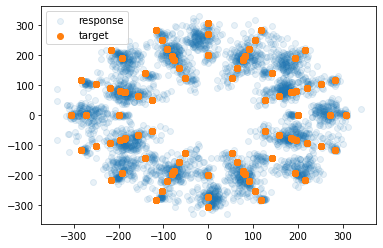

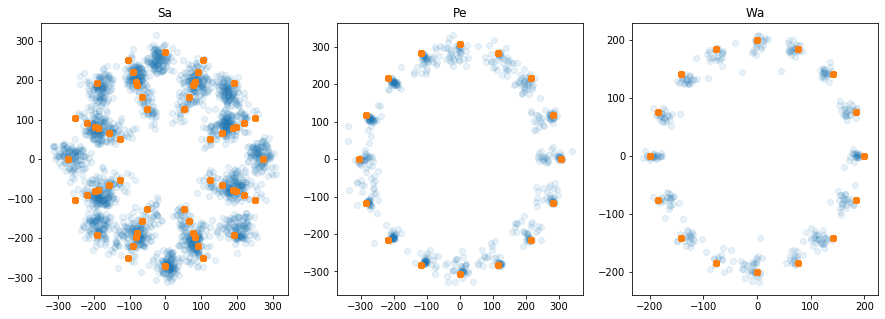

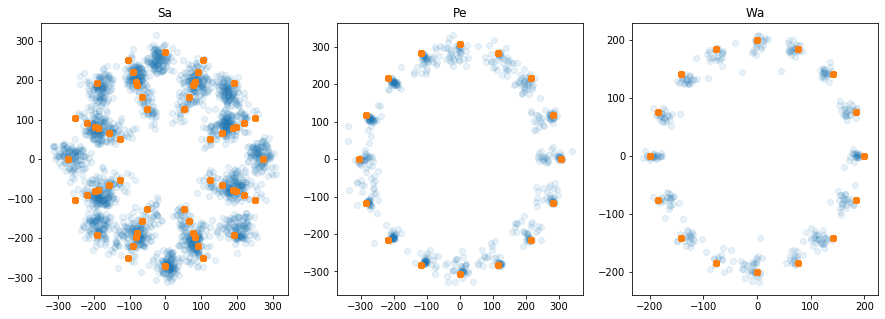

In [137]:
plt.figure()
x_t = [df_dat['targ_xy'].iloc[i][0] for i in range(len(df_dat['targ_xy']))] # target coords
y_t = [df_dat['targ_xy'].iloc[i][1] for i in range(len(df_dat['targ_xy']))]
x_s = [df_dat['saccade_xy'].iloc[i][0] for i in range(len(df_dat['targ_xy']))] # saccade coords
y_s = [df_dat['saccade_xy'].iloc[i][1] for i in range(len(df_dat['targ_xy']))]
plt.scatter(x_s,y_s, alpha=0.1, label='response')
plt.scatter(x_t,y_t, label='target')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
# plot for each monkey seperqately
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.subplot(1,3,i+1)
    x_t = [df_dat['targ_xy'].iloc[i][0] for i in np.where(df_dat['monkey']==m)[0]]
    y_t = [df_dat['targ_xy'].iloc[i][1] for i in np.where(df_dat['monkey']==m)[0]]
    x_s = [df_dat['saccade_xy'].iloc[i][0] for i in np.where(df_dat['monkey']==m)[0]]
    y_s = [df_dat['saccade_xy'].iloc[i][1] for i in np.where(df_dat['monkey']==m)[0]]
    plt.scatter(x_s,y_s, alpha=0.1, label='response')
    plt.scatter(x_t,y_t, label='target')
    plt.title(m)
    

# determine mean of x/y position for each monkey, each session
mean_x = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_y = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_helpx = np.zeros(len(df_dat))
mean_helpy = np.zeros(len(df_dat))
for m in ['Sa', 'Pe', 'Wa']:
    for n in range(max(df_dat['session'].loc[df_dat['monkey']==m])+1):
        # mean of x (sac) for chosen session of monkey
        mean_x[m].append(np.mean([df_dat['saccade_xy'].iloc[i][0] for i in np.where((df_dat['monkey']==m) & (df_dat['session']==n))[0]]))
        # mean of y (sac) for chosen session of monkey
        mean_y[m].append(np.mean([df_dat['saccade_xy'].iloc[i][1] for i in np.where((df_dat['monkey']==m) & (df_dat['session']==n))[0]])) 
        for i in df_dat['saccade_xy'].loc[np.where((df_dat['monkey']==m) & (df_dat['session']==n))].index:
            mean_helpx[i] = df_dat['saccade_xy'][i][0]-mean_x[m][n]
            mean_helpy[i] = df_dat['saccade_xy'][i][1]-mean_y[m][n]

## FROM NOW ON ONLY CONTAINS MEAN CENTERED DATA
df_dat['saccade_xy'] = list(zip(mean_helpx, mean_helpy))
df_dat['saccade_angle'] = convert_cm2deg(mean_helpx, mean_helpy)

df_dat.head()

plt.figure(figsize=(15,5))
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.subplot(1,3,i+1)
    x_t = [df_dat['targ_xy'].iloc[i][0] for i in np.where(df_dat['monkey']==m)[0]]
    y_t = [df_dat['targ_xy'].iloc[i][1] for i in np.where(df_dat['monkey']==m)[0]]
    x_s = [df_dat['saccade_xy'].iloc[i][0] for i in np.where(df_dat['monkey']==m)[0]]
    y_s = [df_dat['saccade_xy'].iloc[i][1] for i in np.where(df_dat['monkey']==m)[0]]
    plt.scatter(x_s,y_s, alpha=0.1, label='response')
    plt.scatter(x_t,y_t, label='target')
    plt.title(m)

In [138]:
df_dat.head()

,trial_id,sp_train,outcome,targ_xy,targ_angle,saccade_xy,saccade_angle,monkey,session,fix,targ_on,targ_off,go_cue,saccade,reward,clockw,hemifield,saccade_xy_mean,saccade_mean
0,1,"(40, 0)\t1.0\n (73, 0)\t1.0\n (51, 1)\t1.0...",CORRECT,"[-81.32022937758153, -196.32440065864844]",247.5,"(-75.5098459377832, -152.99613661823395)",243.731778,Sa,0,1,236,656,3706,243.731778,4036,CCW,l,"(-75.5098459377832, -152.99613661823395)",243.731778
1,2,"(35, 1)\t1.0\n (7, 2)\t1.0\n (12, 2)\t1.0\...",CORRECT,"[196.32440065864844, -81.32022937758153]",337.5,"(200.21376138662484, -55.78135013623153)",344.431686,Sa,0,1,239,659,2189,344.431686,2519,CW,r,"(200.21376138662484, -55.781350136231524)",344.431686
2,4,"(21, 0)\t1.0\n (68, 0)\t1.0\n (87, 0)\t1.0...",CORRECT,"[-81.32022937758157, 196.32440065864844]",112.5,"(-78.14490295211378, 195.89392417751714)",111.747767,Sa,0,1,239,659,2789,111.747767,3109,CW,l,"(-78.14490295211378, 195.89392417751714)",111.747767
3,5,"(6, 0)\t1.0\n (61, 0)\t1.0\n (71, 0)\t1.0\...",CORRECT,"[-196.32440065864844, 81.3202293775816]",157.5,"(-180.44101526618226, 64.75777341836437)",160.257643,Sa,0,1,239,659,2589,160.257643,2879,CW,l,"(-180.44101526618226, 64.75777341836437)",160.257643
4,6,"(79, 0)\t1.0\n (126, 0)\t1.0\n (1, 2)\t1.0...",CORRECT,"[-196.32440065864844, -81.32022937758155]",202.5,"(-187.83890284885962, -89.33745329805883)",205.436077,Sa,0,1,241,660,3090,205.436077,3411,CW,l,"(-187.83890284885962, -89.33745329805883)",205.436077


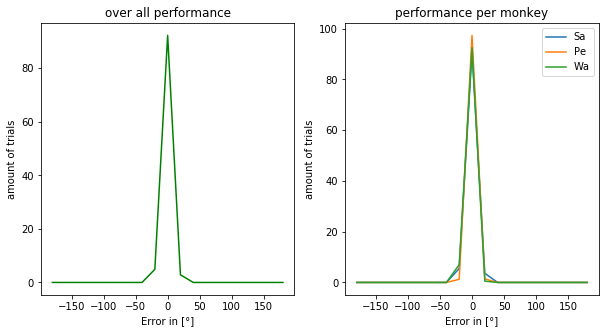

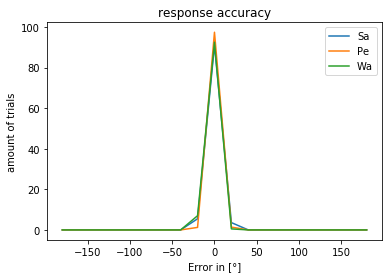

In [139]:

behavior_single = {'err': [], 'delay': []}
behavior_single['err'] = circdist(df_dat['targ_angle'].values*np.pi/180,df_dat['saccade_angle'].values*np.pi/180)*180/np.pi # response offset
behavior_single['delay'] = df_dat['go_cue']-df_dat['targ_off'] # delay time
behavior_single = pd.DataFrame.from_dict(behavior_single)
#print('min delay : '+str(behavior['delay_prev'].min())) # 1528
#print('max delay : '+str(behavior['delay_prev'].max())) # 3050

b_num = 20
b = np.linspace(-180,180,b_num)
histo_full=np.histogram(behavior_single['err'], bins=b)
histo_sep = {'Sa':[],'Pe': [],'Wa':[]}
for m in ['Sa', 'Pe', 'Wa']:
    histo_sep[m]=np.histogram(behavior_single['err'][np.where(df_dat['monkey']==m)[0]], bins=b)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

plt.plot(np.linspace(-180,180,b_num-1), histo_full[0]*100/len(behavior_single['err']), label='full', color='green')
plt.xlabel('Error in [°]')
plt.ylabel('amount of trials')
plt.title('over all performance')

plt.subplot(1,2,2)
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.plot(np.linspace(-180,180,b_num-1), histo_sep[m][0]*100/len(behavior_single['err'][np.where(df_dat['monkey']==m)[0]]), label=m)
plt.xlabel('Error in [°]')
plt.ylabel('amount of trials')
plt.title('performance per monkey')
plt.legend()
plt.show()

plt.figure()
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.plot(np.linspace(-180,180,b_num-1), histo_sep[m][0]*100/len(behavior_single['err'][np.where(df_dat['monkey']==m)[0]]), label=m)
plt.xlabel('Error in [°]')
plt.ylabel('amount of trials')
plt.title('response accuracy')
plt.legend()
#plt.savefig('../Figures/Histogram_responseAcc.png', dpi=100)
plt.show()

In [140]:
print('err maximum = '+str(max(behavior_single['err'])))
print('err minimum = '+str(min(behavior_single['err'])))


err maximum = 22.092512004116717
err minimum = -22.74265511454866


#### Delay dependence, repsonse offset

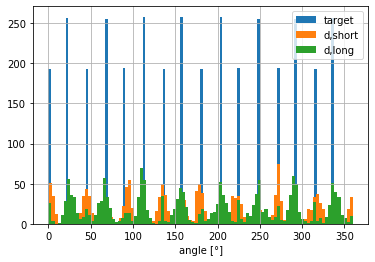

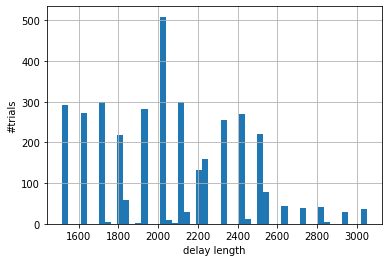

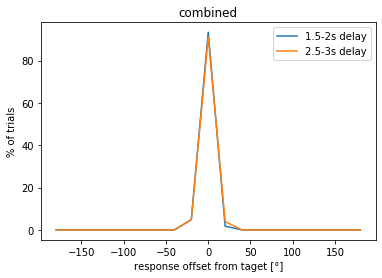

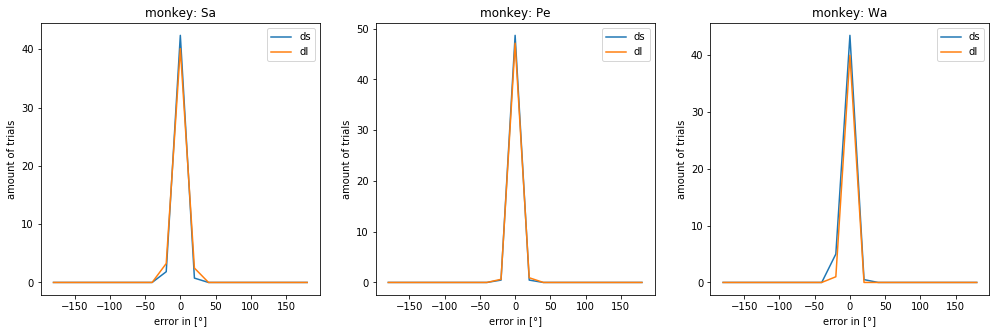

In [141]:
# cut-off value for long VS short delay
cut = np.median(behavior_single['delay'])
cut_split = []
for m in ['Sa', 'Pe', 'Wa']:
    cut_split.append(np.median(behavior_single['delay'].values[np.where(df_dat['monkey']==m)]))
    
# plot targets, responses short VS long
plt.figure()
#plt.subplot(1,2,1)
df_dat['targ_angle'].hist(bins=100, label='target')#df_dat['targ_angle'].hist(bins=b, label='target')
df_dat[(behavior_single['delay']<cut)]['saccade_angle'].hist(bins=100, label='d,short')#df_dat['saccade_angle'].hist(bins=b, label='target')
df_dat[(behavior_single['delay']>cut)]['saccade_angle'].hist(bins=100, label='d,long')#df_dat['saccade_angle'].hist(bins=b, label='target')
#plt.title('short delay')
plt.xlabel('angle [°]')
plt.legend()
#plt.subplot(1,2,2)
#df_dat.loc[(behavior_single['delay']>cut)]['targ_angle'].hist(bins=100, label='target')#df_dat['targ_angle'].hist(bins=b, label='target')
#df_dat[(behavior_single['delay']>cut)]['saccade_angle'].hist(bins=100, label='saccade')#df_dat['saccade_angle'].hist(bins=b, label='target')
#plt.title('long delay')
#plt.xlabel('angle [°]')
#plt.legend()
#plt.show()

# check histogram -> fairly equally spaced delays
plt.figure()
behavior_single['delay'].hist(bins=50)#
plt.xlabel('delay length')
plt.ylabel('#trials')
plt.show()

# determine long/short delays
err_ds = behavior_single.loc[(behavior_single['delay']<cut)]['err']
err_dl = behavior_single.loc[(behavior_single['delay']>cut)]['err']
hist_err_ds = np.histogram(err_ds, bins=b)# bins=b, for Trübutschek plot
hist_err_dl = np.histogram(err_dl, bins=b)# bins=b,

histo_sep_ds = {'Sa':[],'Pe': [],'Wa':[]}
histo_sep_dl = {'Sa':[],'Pe': [],'Wa':[]}
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    # histogram for each monkey for long/short delays
    histo_sep_ds[m]=np.histogram(behavior_single.loc[(behavior_single['delay']<cut_split[i])]['err'].values[np.where(df_dat.loc[(behavior_single['delay']<cut_split[i])]['monkey']==m)[0]], bins=b)
    histo_sep_dl[m]=np.histogram(behavior_single.loc[(behavior_single['delay']>cut_split[i])]['err'].values[np.where(df_dat.loc[(behavior_single['delay']>cut_split[i])]['monkey']==m)[0]], bins=b)


b2 = np.linspace(-180,180,b_num-1)
# response offset
plt.figure()
# behavior['err_prev'].hist(bins=b,histtype='step', density=True, grid=False) # all trials
# seperate trials by delay length
plt.plot(b2, hist_err_ds[0]*100/len(err_ds), label='1.5-2s delay')
plt.plot(b2, hist_err_dl[0]*100/len(err_dl), label='2.5-3s delay')
plt.xlabel('response offset from taget [°]')
plt.ylabel('% of trials')
plt.title('combined')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.subplot(1,3,i+1)
    plt.plot(np.linspace(-180,180,b_num-1), histo_sep_ds[m][0]*100/len(behavior_single['err'][np.where(df_dat['monkey']==m)[0]]), label='ds')
    plt.plot(np.linspace(-180,180,b_num-1), histo_sep_dl[m][0]*100/len(behavior_single['err'][np.where(df_dat['monkey']==m)[0]]), label='dl')
    plt.title('monkey: '+str(m))
    plt.xlabel('error in [°]')
    plt.ylabel('amount of trials')
    plt.legend()
#plt.savefig('../Figures/histogram_delay_dependence_monkeys.png', dpi=150)
plt.show()


In [142]:
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    print('Monkey '+str(m)+': '+str(spearmanr((behavior_single['err'][np.where(df_dat['monkey']==m)[0]])**2, behavior_single['delay'][np.where(df_dat['monkey']==m)[0]])))


Monkey Sa: SpearmanrResult(correlation=0.06546565319612897, pvalue=0.0009338657819791485)
Monkey Pe: SpearmanrResult(correlation=0.007972594295306603, pvalue=0.8396012651564768)
Monkey Wa: SpearmanrResult(correlation=-0.11134467554951698, pvalue=0.02595710365052257)


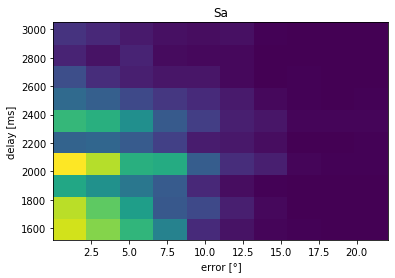

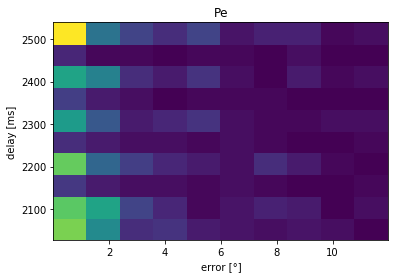

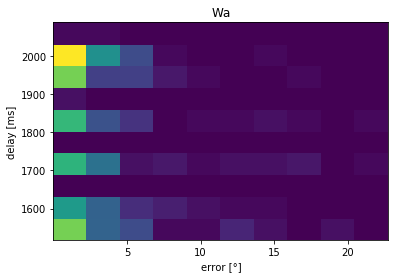

In [143]:
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.figure()
    plt.hist2d(abs(behavior_single['err'][np.where(df_dat['monkey']==m)[0]]), behavior_single['delay'][np.where(df_dat['monkey']==m)[0]],density=True);
    plt.title(m)
    plt.xlabel('error [°]')
    plt.ylabel('delay [ms]')
    plt.show()


xerr vs delay Sa : SpearmanrResult(correlation=0.007158067336651589, pvalue=0.71772215293353)
yerr vs delay Sa : SpearmanrResult(correlation=-0.03714139179852573, pvalue=0.060603170211750296)


<Figure size 432x288 with 0 Axes>

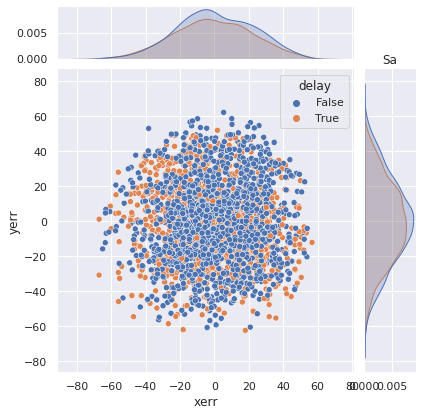

xerr vs delay Pe : SpearmanrResult(correlation=0.0010365144524994924, pvalue=0.9790068818932283)
yerr vs delay Pe : SpearmanrResult(correlation=0.014216396473071075, pvalue=0.7181517642354642)


<Figure size 432x288 with 0 Axes>

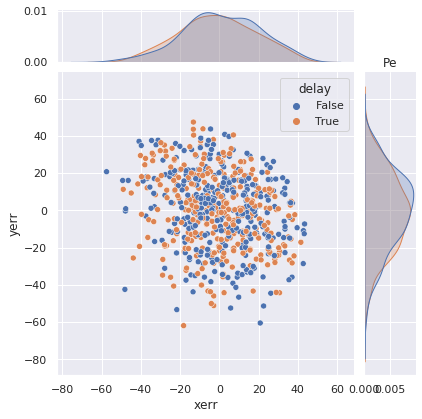

xerr vs delay Wa : SpearmanrResult(correlation=-0.01754733679802574, pvalue=0.7264322190952822)
yerr vs delay Wa : SpearmanrResult(correlation=0.06310893057702241, pvalue=0.207855424805376)


<Figure size 432x288 with 0 Axes>

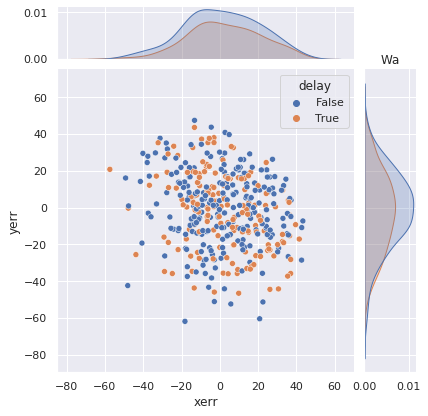

In [144]:
xerr={'Sa':np.zeros(len(df_dat['targ_xy'][np.where(df_dat['monkey']=='Sa')[0]])),'Pe':np.zeros(len(df_dat['targ_xy'][np.where(df_dat['monkey']=='Pe')[0]])),'Wa':np.zeros(len(df_dat['targ_xy'][np.where(df_dat['monkey']=='Wa')[0]]))}
yerr={'Sa':np.zeros(len(df_dat['targ_xy'][np.where(df_dat['monkey']=='Sa')[0]])),'Pe':np.zeros(len(df_dat['targ_xy'][np.where(df_dat['monkey']=='Pe')[0]])),'Wa':np.zeros(len(df_dat['targ_xy'][np.where(df_dat['monkey']=='Wa')[0]]))}

for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    for s in range(len(np.where(df_dat['monkey']==m)[0])):# get data for only one monkey
        xerr[m][s] = circdist(df_dat['targ_xy'][s][0]*np.pi/180, df_dat['saccade_xy'][s][0]*np.pi/180)*180/np.pi
        yerr[m][s] = circdist(df_dat['targ_xy'][s][1]*np.pi/180, df_dat['saccade_xy'][s][1]*np.pi/180)*180/np.pi

    print('xerr vs delay '+str(m)+' : '+str(spearmanr((xerr[m])**2, behavior_single['delay'][np.where(df_dat['monkey']==m)[0]])))
    print('yerr vs delay '+str(m)+' : '+str(spearmanr((yerr[m])**2, behavior_single['delay'][np.where(df_dat['monkey']==m)[0]])))

    xy = {'xerr': xerr[m], 'yerr': yerr[m], 'delay': behavior_single['delay'][np.where(df_dat['monkey']==m)[0]].values>cut_split[i]}
    df_xy = pd.DataFrame(xy)

    plt.figure()
    sns.set_theme()
    XYpos = sns.jointplot(data=df_xy, x="xerr", y="yerr", hue="delay", marginal_ticks=True)# short delay=False, long delay=True
    plt.title(m)
    plt.show()


##### Dependence #trials on delay?

In [16]:
spearmanr(behavior_single.groupby(['delay'])['delay'].count(), list(behavior_single.groupby(['delay']).groups))

SpearmanrResult(correlation=-0.15709736374590205, pvalue=0.029978721285986915)

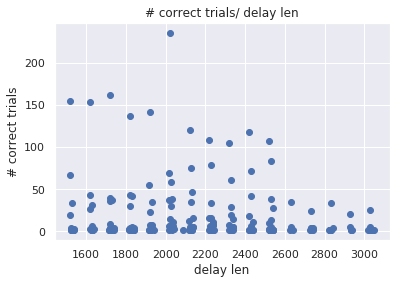

In [17]:
plt.figure()
plt.scatter(list(behavior_single.groupby(['delay']).groups), behavior_single.groupby(['delay'])['delay'].count())
plt.title('# correct trials/ delay len')
plt.xlabel('delay len')
plt.ylabel('# correct trials')
#plt.plot(behavior_single.groupby(['delay']).mean())
plt.show()

# Serial bias analysis

### Serial dependence

In [145]:
# create list with values needed for serial bias calculation (ONLY if two trials are in a row)
# no need to extra specify sessions, trial_id changes from large # to small #
serial = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [], 'response_curr': [], 'delay_curr': [], 'monkey': []}
for idx in df_dat.index[:-1]:
    if ((df_dat['trial_id'][idx]+1) == (df_dat['trial_id'][idx+1])):
        serial['trial_id'].append(idx)
        serial['target_prev'].append(round(df_dat['targ_angle'][idx]*np.pi/180, 5))
        serial['response_prev'].append(round(df_dat['saccade_angle'][idx]*np.pi/180, 5))
        serial['delay_prev'].append(df_dat['go_cue'][idx]-df_dat['targ_off'][idx])
        serial['target_curr'].append(round(df_dat['targ_angle'][idx+1]*np.pi/180, 5))
        serial['response_curr'].append(round(df_dat['saccade_angle'][idx+1]*np.pi/180, 5))
        serial['delay_curr'].append(df_dat['go_cue'][idx+1]-df_dat['targ_off'][idx+1]) 
        serial['monkey'].append(df_dat['monkey'][idx])

rel_loc, err = calc_errorcurve(serial)

sb = {'rel_loc': rel_loc*180/np.pi, 'err': err*180/np.pi, 'delay_prev': serial['delay_prev'],\
      'delay_curr': serial['delay_curr'], 'monkey': serial['monkey']}
df_sb = pd.DataFrame(sb)

sb_onesided = {'rel_loc': rel_loc*180/np.pi*np.sign(rel_loc),\
               'err': np.array([err[i]*180/np.pi*np.sign(rel_loc[i]) if rel_loc[i] !=0 else err[i]*180/np.pi for i in range(len(rel_loc))]),\
               'delay_prev': serial['delay_prev'], 'delay_curr': serial['delay_curr'], 'monkey': serial['monkey']}
df_sb_onesided = pd.DataFrame(sb_onesided)



#### Fit DoG curves

In [146]:
from scipy.optimize import curve_fit 

### Define curves to fit
# use DoG
def test_func(x,a,w):
    return a * w * x * (np.sqrt(2)/np.exp(-0.5)) * np.exp(-(w*x)**2)

# Clifford model
def test_func2(x,s,c):
    return np.sin(x)/(np.sqrt((s*np.cos(x)-c)**2+np.sin(x)**2))


x_data = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data = {'Sa':[], 'Pe':[], 'Wa':[]}
_ = {'Sa':[], 'Pe':[], 'Wa':[]}
x_data_onesided = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_onesided = {'Sa':[], 'Pe':[], 'Wa':[]}
params = {'Sa':[], 'Pe':[], 'Wa':[]}
param_cov = {'Sa':[], 'Pe':[], 'Wa':[]}
params_onesided = {'Sa':[], 'Pe':[], 'Wa':[]}
param_onesided_cov = {'Sa':[], 'Pe':[], 'Wa':[]}
# fit curve for every monkey
for m in ['Sa','Pe','Wa']:
    # extract data for each monkey
    x_data[m] = sb['rel_loc'][np.where(df_sb['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
    y_data[m] = sb['err'][np.where(df_sb['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['err']#
    x_data_onesided[m] = sb_onesided['rel_loc'][np.where(df_sb['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
    y_data_onesided[m] = sb_onesided['err'][np.where(df_sb['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['err']#

    # fit params for DoG
    params[m], param_cov[m] = curve_fit(test_func, x_data[m], y_data[m], p0=[5, 0.015])#p0 = [amplitude, width] 
    params_onesided[m], param_onesided_cov[m] = curve_fit(test_func, x_data_onesided[m], y_data_onesided[m], p0=[5, 0.015])


#### Plot serial bias

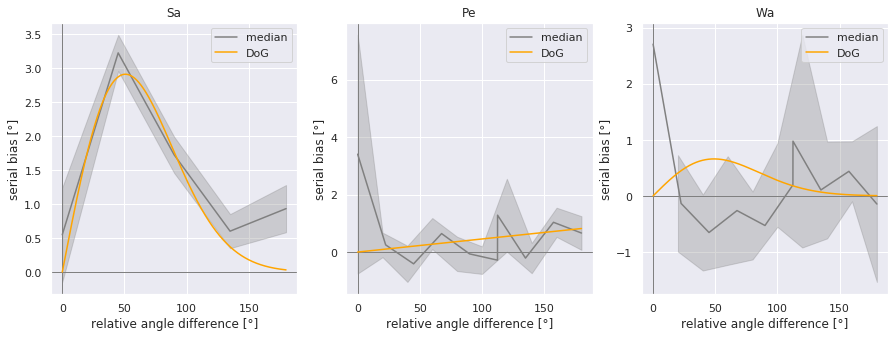

In [147]:
# plot serial bias curve, both sides
x_new = np.linspace(-180, 180, 1000)
x_new_onesided = np.linspace(0, 180, 500)


plt.figure(figsize=(15,5))
for i,m in enumerate(['Sa','Pe','Wa']):#
    num_pos = len(df_sb.loc[df_sb['monkey']==m].groupby('rel_loc')) # number of x-positions in SB curve
    x_full = np.linspace(-180,180,num_pos)
    x_full_onesided = np.linspace(0,180,int(num_pos/2+1))
    
#    plt.figure(figsize=(10,5))
#    plt.axhline(color='grey', linewidth=1)
#    plt.axvline(color='grey', linewidth=1)
#    plt.scatter(x_data[m], y_data[m], label='data', alpha=0.2)
#    # plots median of the values in each position
#    plt.fill_between(x_full,df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').median()['err']+df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').sem()['err'], df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').median()['err']-df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
#    plt.plot(df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
#    # DoG fit of data
#    plt.plot(x_new, test_func(x_new, params[m][0], params[m][1]), label='DoG',color='orange')
#    # Clifford fit
#    # plt.plot(x_new, test_func2(x_new, params2[0], params2[1]), label='Clifford',color='cyan')
#    plt.xlabel('relative angle difference [°]')
#    plt.ylabel('serial bias [°]')
#    plt.title(m)
#    plt.legend()
#    #plt.savefig('../Figures/serialBias_full_Sa0.png', dpi=150)
#    plt.show()
#    print(params)#, params2)

    # plot serial bias curve, single sided
    #plt.figure()
    plt.subplot(1,3,i+1)
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    #plt.scatter(x_data_onesided[m], y_data_onesided[m], alpha=0.2, label='data')
    # plots median of the values in each position
    plt.fill_between(x_full_onesided,df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').median()['err']+df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').median()['err']-df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided[m][0], params_onesided[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    plt.legend()
    plt.title(m)
#plt.savefig('../Figures/serialBias_oneSided_allmonkeys.png', dpi=150)
plt.show()
#    print(params_onesided)#, params2_onesided)
#    print('Amount of data: '+str(len(x_data_onesided[m])))



### Serial bias into PAST

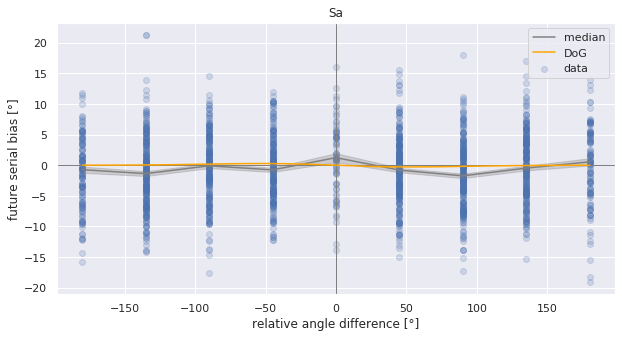

{'Sa': array([-0.28198668,  0.01342278]), 'Pe': array([0.44044119, 0.0263447 ]), 'Wa': array([0.25792985, 0.01754617])}


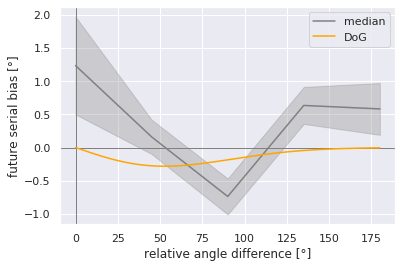

{'Sa': array([-0.28198668,  0.01342278]), 'Pe': array([0.44044119, 0.0263447 ]), 'Wa': array([0.25792985, 0.01754617])}
Amount of data: 1658


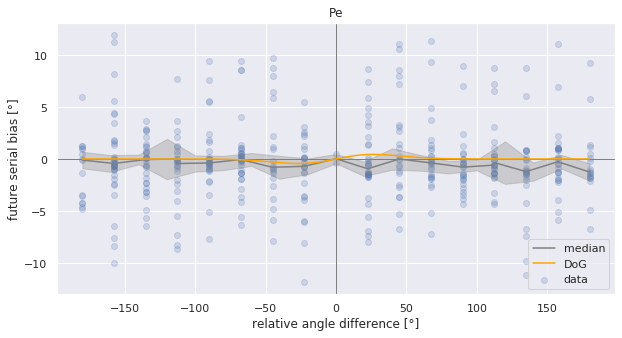

{'Sa': array([-0.28198668,  0.01342278]), 'Pe': array([0.44044119, 0.0263447 ]), 'Wa': array([0.25792985, 0.01754617])}


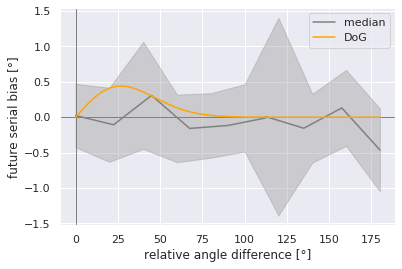

{'Sa': array([-0.28198668,  0.01342278]), 'Pe': array([0.44044119, 0.0263447 ]), 'Wa': array([0.25792985, 0.01754617])}
Amount of data: 411


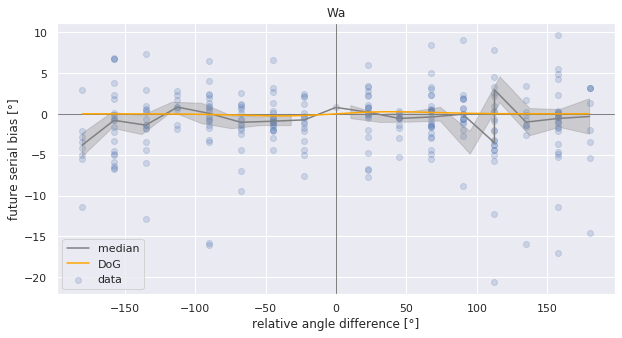

{'Sa': array([-0.28198668,  0.01342278]), 'Pe': array([0.44044119, 0.0263447 ]), 'Wa': array([0.25792985, 0.01754617])}


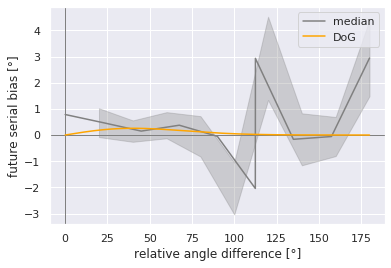

{'Sa': array([-0.28198668,  0.01342278]), 'Pe': array([0.44044119, 0.0263447 ]), 'Wa': array([0.25792985, 0.01754617])}
Amount of data: 263


In [148]:
# create list with values needed for serial bias calculation (ONLY if two trials are in a row)
serial_past = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [], 'response_curr': [], 'delay_curr': [], 'monkey':[]}
for idx in df_dat.index[:-1]:
    if ((df_dat['trial_id'][idx]+1) == (df_dat['trial_id'][idx+1])):
        serial_past['trial_id'].append(idx)
        serial_past['target_prev'].append(round(df_dat['targ_angle'][idx+1]*np.pi/180, 5))
        serial_past['response_prev'].append(round(df_dat['saccade_angle'][idx+1]*np.pi/180, 5))
        serial_past['delay_prev'].append(df_dat['go_cue'][idx+1]-df_dat['targ_off'][idx+1])
        serial_past['target_curr'].append(round(df_dat['targ_angle'][idx]*np.pi/180, 5))
        serial_past['response_curr'].append(round(df_dat['saccade_angle'][idx]*np.pi/180, 5))
        serial_past['delay_curr'].append(df_dat['go_cue'][idx]-df_dat['targ_off'][idx]) 
        serial_past['monkey'].append(df_dat['monkey'][idx])


rel_loc_past, err_past = calc_errorcurve(serial_past)

sb_past = {'rel_loc': rel_loc_past*180/np.pi, 'err': err_past*180/np.pi, 'delay_prev': serial_past['delay_prev'], 'delay_curr': serial_past['delay_curr'], 'monkey': serial_past['monkey']}
df_sb_past = pd.DataFrame(sb_past)

sb_onesided_past = {'rel_loc': rel_loc_past*180/np.pi*np.sign(rel_loc_past),\
                    'err': np.array([err_past[i]*180/np.pi*np.sign(rel_loc_past[i]) if rel_loc_past[i] !=0 else err_past[i]*180/np.pi for i in range(len(rel_loc_past))]),\
                    'delay_prev': serial_past['delay_prev'], 'delay_curr': serial_past['delay_curr'], 'monkey': serial_past['monkey']}
df_sb_onesided_past = pd.DataFrame(sb_onesided_past)


################################ FIT DoG

x_data_past = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_past = {'Sa':[], 'Pe':[], 'Wa':[]}
x_data_onesided_past = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_onesided_past = {'Sa':[], 'Pe':[], 'Wa':[]}
params_past = {'Sa':[], 'Pe':[], 'Wa':[]}
param_cov_past = {'Sa':[], 'Pe':[], 'Wa':[]}
params_onesided_past = {'Sa':[], 'Pe':[], 'Wa':[]}
param_onesided_cov_past = {'Sa':[], 'Pe':[], 'Wa':[]}
# fit curve for every monkey
for m in ['Sa','Pe','Wa']:
    # extract data for each monkey
    x_data_past[m] = sb_past['rel_loc'][np.where(df_sb_past['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
    y_data_past[m] = sb_past['err'][np.where(df_sb_past['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['err']#
    x_data_onesided_past[m] = sb_onesided_past['rel_loc'][np.where(df_sb_past['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
    y_data_onesided_past[m] = sb_onesided_past['err'][np.where(df_sb_past['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['err']#

    # fit params for DoG
    params_past[m], param_cov_past[m] = curve_fit(test_func, x_data_past[m], y_data_past[m], p0=[5, 0.015])#p0 = [amplitude, width] 
    params_onesided_past[m], param_onesided_cov_past[m] = curve_fit(test_func, x_data_onesided_past[m], y_data_onesided_past[m], p0=[5, 0.015])


# plot serial bias curve

for m in ['Sa','Pe','Wa']:#
    num_pos_past = len(df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc')) # number of x-positions in SB curve
    x_full_past = np.linspace(-180,180,num_pos_past)
    x_full_onesided_past = np.linspace(0,180,int(num_pos_past/2+1))
    
    plt.figure(figsize=(10,5))
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    plt.scatter(x_data_past[m], y_data_past[m], label='data', alpha=0.2)
    # plots median of the values in each position
    plt.fill_between(x_full_past,df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').median()['err']+df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').median()['err']-df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new, test_func(x_new, params_past[m][0], params_past[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2[0], params2[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('future serial bias [°]')
    plt.title(m)
    plt.legend()
    plt.savefig('../Figures/serialBiasFuture_full_Sa0.png', dpi=150)
    plt.show()
    print(params_past)#, params2)

    # plot serial bias curve, single sided
    plt.figure()
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    # plt.scatter(x_data_onesided, y_data_onesided, label='data')
    # plots median of the values in each position
    plt.fill_between(x_full_onesided_past,df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').median()['err']+df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').median()['err']-df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_past[m][0], params_onesided_past[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('future serial bias [°]')
    #plt.savefig('../Figures/serialBiasFuture_oneSided_Sa0.png', dpi=150)
    plt.legend()
    plt.show()
    print(params_onesided_past)#, params2_onesided)
    print('Amount of data: '+str(len(x_data_onesided_past[m])))





#### Serial bias dependence on delay length

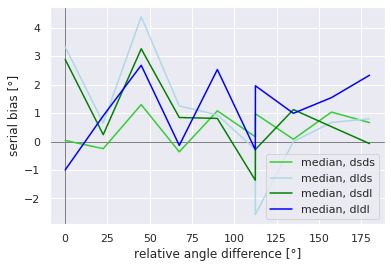

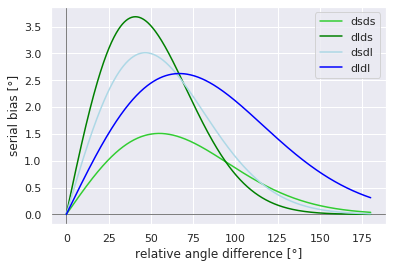

In [149]:
x_data_dsds = df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)]['rel_loc']
y_data_dsds = df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)]['err']
x_data_dlds = df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)]['rel_loc']
y_data_dlds = df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)]['err']
x_data_dsdl = df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)]['rel_loc']
y_data_dsdl = df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)]['err']
x_data_dldl = df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)]['rel_loc']
y_data_dldl = df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)]['err']

params_dsds, param_cov_dsds = curve_fit(test_func, x_data_dsds, y_data_dsds, p0=[3, 0.015])
params_dlds, param_cov_dlds = curve_fit(test_func, x_data_dlds, y_data_dlds, p0=[3, 0.015])
params_dsdl, param_cov_dsdl = curve_fit(test_func, x_data_dsdl, y_data_dsdl, p0=[3, 0.015])
params_dldl, param_cov_dldl = curve_fit(test_func, x_data_dldl, y_data_dldl, p0=[3, 0.015])

# plot serial bias curve, single sided
plt.figure()
#plt.scatter(x_data_dlds, y_data_dlds, alpha=0.1, color='red', label='data ds')
#plt.scatter(x_data_dldl, y_data_dldl, alpha=0.1, color='blue', label='data dl')
#plt.subplot(2,1,1)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
#plt.fill_between(x_full_onesided, df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err']- df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err'] + df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').sem()['err'], color='limegreen', alpha=0.3)
plt.plot(df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err'], color='limegreen', label='median, dsds')
#plt.fill_between(x_full_onesided, df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err']- df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err'] + df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').sem()['err'], color='lightblue', alpha=0.3)
plt.plot(df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err'], color='lightblue', label='median, dlds')
#plt.fill_between(x_full_onesided, df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err']- df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err'] + df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').sem()['err'], color='green', alpha=0.3)
plt.plot(df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err'], color='green', label='median, dsdl')
#plt.fill_between(x_full_onesided, df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err']- df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err'] + df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').sem()['err'], color='blue', alpha=0.3)
plt.plot(df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err'], color='blue', label='median, dldl')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.legend()
plt.show()

# DoG fit of data
plt.figure()
#plt.subplot(2,1,2)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsds[0], params_dsds[1]), label='dsds',color='limegreen')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dlds[0], params_dlds[1]), label='dlds',color='green')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsdl[0], params_dsdl[1]), label='dsdl',color='lightblue')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dldl[0], params_dldl[1]), label='dldl',color='blue')
# Clifford fit
# plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')

#plt.subplot(3,1,3)
#plt.axhline(color='grey', linewidth=1)
#plt.axvline(color='grey', linewidth=1)
#plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsds[0], params_dsds[1]), label='dsds',color='limegreen')
#plt.plot(x_new_onesided, test_func(x_new_onesided, params_dlds[0], params_dlds[1]), label='dlds',color='green')
#plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsdl[0], params_dsdl[1]), label='dsdl',color='lightblue')
#plt.plot(x_new_onesided, test_func(x_new_onesided, params_dldl[0], params_dldl[1]), label='dldl',color='blue')
## Clifford fit
## plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
#plt.xlabel('relative angle difference [°]')
#plt.ylabel('serial bias [°]')
#plt.ylim([0,4])

plt.legend()
plt.show()


-> Too little data (~ 150 data points/curve)

-> Find another fit

### in past

In [ ]:
x_data_dsds_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)]['rel_loc']
y_data_dsds_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)]['err']
x_data_dlds_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)]['rel_loc']
y_data_dlds_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)]['err']
x_data_dsdl_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)]['rel_loc']
y_data_dsdl_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)]['err']
x_data_dldl_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)]['rel_loc']
y_data_dldl_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)]['err']

params_dsds_past, param_cov_dsds_past = curve_fit(test_func, x_data_dsds_past, y_data_dsds_past, p0=[3, 0.015])
params_dlds_past, param_cov_dlds_past = curve_fit(test_func, x_data_dlds_past, y_data_dlds_past, p0=[3, 0.015])
params_dsdl_past, param_cov_dsdl_past = curve_fit(test_func, x_data_dsdl_past, y_data_dsdl_past, p0=[3, 0.015])
params_dldl_past, param_cov_dldl_past = curve_fit(test_func, x_data_dldl_past, y_data_dldl_past, p0=[3, 0.015])

# plot serial bias curve, single sided
plt.figure()

#plt.subplot(2,1,1)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
plt.plot(df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err'], color='limegreen', label='median, dsds')
#plt.fill_between(x_full_onesided, df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err']- df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err'] + df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').sem()['err'], color='limegreen', alpha=0.3, label='median, dsds')
plt.plot(df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err'], color='lightblue', label='median, dlds')
#plt.fill_between(x_full_onesided, df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err']- df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err'] + df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').sem()['err'], color='lightblue', alpha=0.3, label='median, dlds')
plt.plot(df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err'], color='green', label='median, dsdl')
#plt.fill_between(x_full_onesided, df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err']- df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err'] + df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').sem()['err'], color='green', alpha=0.3, label='median, dsdl')
plt.plot(df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err'], color='blue', label='median, dldl')
#plt.fill_between(x_full_onesided, df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err']- df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err'] + df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').sem()['err'], color='blue', alpha=0.3, label='median, dldl')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.legend()
plt.show()

plt.figure()
plt.subplot(2,1,2)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
#plt.scatter(x_data_dsdl, y_data_dsdl, alpha=0.1, color='red', label='data dsdl')
#plt.scatter(x_data_dsds, y_data_dsds, alpha=0.1, color='blue', label='data dl')
## DoG fit of data
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsds_past[0], params_dsds_past[1]), label='dsds',color='limegreen')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dlds_past[0], params_dlds_past[1]), label='dlds',color='green')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsdl_past[0], params_dsdl_past[1]), label='dsdl',color='lightblue')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dldl_past[0], params_dldl_past[1]), label='dldl',color='blue')
# Clifford fit
# plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.legend()
plt.show()



ValueError: `ydata` must not be empty!

-> doesn't seem like cohesive dependence on future

-> find other fit

# Serial dependence based on hemifields

In [150]:
# create list with values needed for serial bias calculation (ONLY if two trials are in a row, ONLY if in SAME/OPPOSING hemifields)
# no need to extra specify sessions, trial_id changes from large # to small #
serial_sameH = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [], 'response_curr': [], 'delay_curr': [], 'monkey': [], 'session':[]}
serial_oppH = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [], 'response_curr': [], 'delay_curr': [], 'monkey': [], 'session':[]}
for idx in df_dat.index[:-1]:
    if ((df_dat['trial_id'][idx]+1) == (df_dat['trial_id'][idx+1])):# if two consecutive trials
        # if trials in same hemifield
        if (df_dat['hemifield'][idx] == df_dat['hemifield'][idx+1]):
            serial_sameH['trial_id'].append(idx)
            serial_sameH['target_prev'].append(round(df_dat['targ_angle'][idx]*np.pi/180, 5))
            serial_sameH['response_prev'].append(round(df_dat['saccade_angle'][idx]*np.pi/180, 5))
            serial_sameH['delay_prev'].append(df_dat['go_cue'][idx]-df_dat['targ_off'][idx])
            serial_sameH['target_curr'].append(round(df_dat['targ_angle'][idx+1]*np.pi/180, 5))
            serial_sameH['response_curr'].append(round(df_dat['saccade_angle'][idx+1]*np.pi/180, 5))
            serial_sameH['delay_curr'].append(df_dat['go_cue'][idx+1]-df_dat['targ_off'][idx+1]) 
            serial_sameH['monkey'].append(df_dat['monkey'][idx])
            serial_sameH['session'].append(df_dat['session'][idx])
        # if trials in opposite hemifield
        else:
            serial_oppH['trial_id'].append(idx)
            serial_oppH['target_prev'].append(round(df_dat['targ_angle'][idx]*np.pi/180, 5))
            serial_oppH['response_prev'].append(round(df_dat['saccade_angle'][idx]*np.pi/180, 5))
            serial_oppH['delay_prev'].append(df_dat['go_cue'][idx]-df_dat['targ_off'][idx])
            serial_oppH['target_curr'].append(round(df_dat['targ_angle'][idx+1]*np.pi/180, 5))
            serial_oppH['response_curr'].append(round(df_dat['saccade_angle'][idx+1]*np.pi/180, 5))
            serial_oppH['delay_curr'].append(df_dat['go_cue'][idx+1]-df_dat['targ_off'][idx+1]) 
            serial_oppH['monkey'].append(df_dat['monkey'][idx])
            serial_oppH['session'].append(df_dat['session'][idx])

rel_loc_sameH, err_sameH = calc_errorcurve(serial_sameH)
rel_loc_oppH, err_oppH = calc_errorcurve(serial_oppH)

sb_sameH = {'rel_loc': rel_loc_sameH*180/np.pi, 'err': err_sameH*180/np.pi, 'delay_prev': serial_sameH['delay_prev'], 'delay_curr': serial_sameH['delay_curr'], 'target_prev':np.round(np.array(serial_sameH['target_prev'])*180/np.pi,1), 'target_curr':np.round(np.array(serial_sameH['target_curr'])*180/np.pi,1), 'monkey': serial_sameH['monkey'], 'session': serial_sameH['session']}
df_sb_sameH = pd.DataFrame(sb_sameH)
sb_onesided_sameH = {'rel_loc': rel_loc_sameH*180/np.pi*np.sign(rel_loc_sameH),\
                     'err': np.array([err_sameH[i]*180/np.pi*np.sign(rel_loc_sameH[i]) if rel_loc_sameH[i] !=0 else err_sameH[i]*180/np.pi for i in range(len(rel_loc_sameH))]),\
                     'delay_prev': serial_sameH['delay_prev'], 'delay_curr': serial_sameH['delay_curr'], 'target_prev':np.round(np.array(serial_sameH['target_prev'])*180/np.pi,1), 'target_curr':np.round(np.array(serial_sameH['target_curr'])*180/np.pi,1), 'monkey': serial_sameH['monkey'], 'session': serial_sameH['session']}
df_sb_onesided_sameH = pd.DataFrame(sb_onesided_sameH)

sb_oppH = {'rel_loc': rel_loc_oppH*180/np.pi, 'err': err_oppH*180/np.pi, 'delay_prev': serial_oppH['delay_prev'], 'delay_curr': serial_oppH['delay_curr'], 'target_prev':np.round(np.array(serial_oppH['target_prev'])*180/np.pi, 1), 'target_curr':np.round(np.array(serial_oppH['target_curr'])*180/np.pi, 1), 'monkey': serial_oppH['monkey'], 'session': serial_oppH['session']}
df_sb_oppH = pd.DataFrame(sb_oppH)
sb_onesided_oppH = {'rel_loc': rel_loc_oppH*180/np.pi*np.sign(rel_loc_oppH),\
                    'err': np.array([err_oppH[i]*180/np.pi*np.sign(rel_loc_oppH[i]) if rel_loc_oppH[i] !=0 else err_oppH[i]*180/np.pi for i in range(len(rel_loc_oppH))]),\
                    'delay_prev': serial_oppH['delay_prev'], 'delay_curr': serial_oppH['delay_curr'], 'target_prev':np.round(np.array(serial_oppH['target_prev'])*180/np.pi, 1), 'target_curr':np.round(np.array(serial_oppH['target_curr'])*180/np.pi, 1), 'monkey': serial_oppH['monkey'], 'session': serial_oppH['session']}
df_sb_onesided_oppH = pd.DataFrame(sb_onesided_oppH)



### DoG fit

In [151]:
[np.where((df_sb_sameH['monkey']==m) & (df_sb_sameH['session']==0))[0]]

[array([ 964,  965,  966,  967,  968,  969,  970,  971,  972,  973,  974,
         975,  976,  977,  978,  979,  980,  981,  982,  983,  984,  985,
         986,  987,  988,  989,  990,  991,  992,  993,  994,  995,  996,
         997,  998,  999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007,
        1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018,
        1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029,
        1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040,
        1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051,
        1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062,
        1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073,
        1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084,
        1085, 1086, 1087])]

In [152]:
for n in range(len(df_sb_sameH.loc[df_sb_sameH['monkey']=='Sa'].groupby(['session']).groups.keys())):
    print(n)

0
1
2


In [153]:
x_data_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
x_data_onesided_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_onesided_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
params_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
param_cov_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
params_onesided_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
param_onesided_cov_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}

x_data_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
x_data_onesided_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_onesided_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
params_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
param_cov_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
params_onesided_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
param_onesided_cov_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
# fit curve for every monkey
for m in ['Sa','Pe','Wa']:
    for n in range(len(df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby(['session']).groups.keys())): #for each session per monkey
        # extract data for each monkey
        x_data_sameH[m] = sb_sameH['rel_loc'][np.where((df_sb_sameH['monkey']==m) & (df_sb_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_sameH[m] = sb_sameH['err'][np.where((df_sb_sameH['monkey']==m) & (df_sb_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#
        x_data_onesided_sameH[m] = sb_onesided_sameH['rel_loc'][np.where((df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_onesided_sameH[m] = sb_onesided_sameH['err'][np.where((df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#

        # fit params for DoG
        params_sameH[m], param_cov_sameH[m] = curve_fit(test_func, x_data_sameH[m], y_data_sameH[m], p0=[5, 0.015])#p0 = [amplitude, width] 
        params_onesided_sameH[m], param_onesided_cov_sameH[m] = curve_fit(test_func, x_data_onesided_sameH[m], y_data_onesided_sameH[m], p0=[5, 0.015])

        # OPPOSITE hemifield
        x_data_oppH[m] = sb_oppH['rel_loc'][np.where((df_sb_oppH['monkey']==m) & (df_sb_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_oppH[m] = sb_oppH['err'][np.where((df_sb_oppH['monkey']==m) & (df_sb_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#
        x_data_onesided_oppH[m] = sb_onesided_oppH['rel_loc'][np.where((df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_onesided_oppH[m] = sb_onesided_oppH['err'][np.where((df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#

        # fit params for DoG
        params_oppH[m], param_cov_oppH[m] = curve_fit(test_func, x_data_oppH[m], y_data_oppH[m], p0=[5, 0.015])#p0 = [amplitude, width] 
        params_onesided_oppH[m], param_onesided_cov_oppH[m] = curve_fit(test_func, x_data_onesided_oppH[m], y_data_onesided_oppH[m], p0=[5, 0.015])

        print(str(m)+str(n)+': difference err, same/opp hemifield: '+str(ttest_ind(df_sb_onesided_sameH.loc[(df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n)]['err'].values,df_sb_onesided_oppH.loc[(df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n)]['err'].values)))


Sa0: difference err, same/opp hemifield: Ttest_indResult(statistic=2.174786209710519, pvalue=0.03004535818588795)
Sa1: difference err, same/opp hemifield: Ttest_indResult(statistic=0.008653293124494097, pvalue=0.993099063181298)
Sa2: difference err, same/opp hemifield: Ttest_indResult(statistic=1.9008324698662702, pvalue=0.05785221384738941)
Pe0: difference err, same/opp hemifield: Ttest_indResult(statistic=0.2698386586152965, pvalue=0.7874204725008401)
Wa0: difference err, same/opp hemifield: Ttest_indResult(statistic=-2.854221370838965, pvalue=0.004660428937585807)


### check distribution of trials/errors within/across hemifields

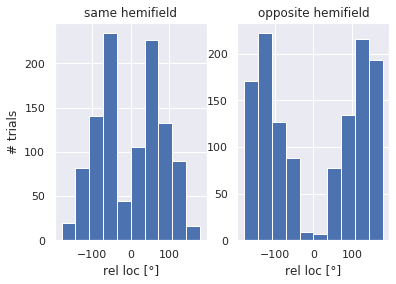

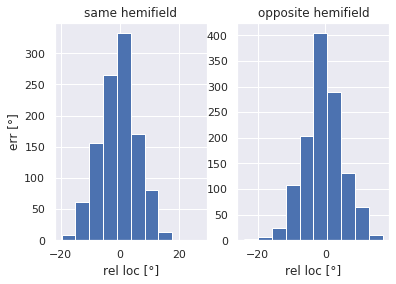

In [53]:
plt.figure()
plt.subplot(121)
plt.hist(rel_loc_sameH*180/np.pi, label='same')
plt.xlabel('rel loc [°]')
plt.ylabel('# trials')
plt.title('same hemifield')
plt.subplot(122)
plt.hist(rel_loc_oppH*180/np.pi, label='opp')
plt.title('opposite hemifield')
plt.xlabel('rel loc [°]')
plt.show()

plt.figure()
plt.subplot(121)
plt.hist(err_sameH*180/np.pi, label='same')
plt.xlabel('rel loc [°]')
plt.ylabel('err [°]')
plt.title('same hemifield')
plt.subplot(122)
plt.hist(err_oppH*180/np.pi, label='opp')
plt.title('opposite hemifield')
plt.xlabel('rel loc [°]')
plt.show()


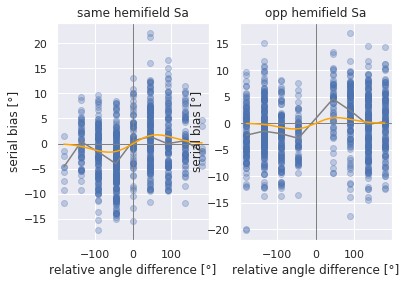

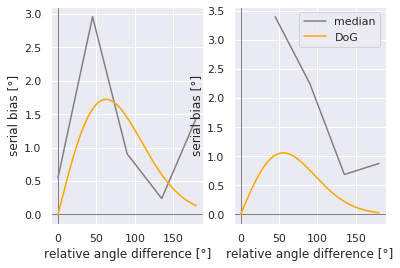

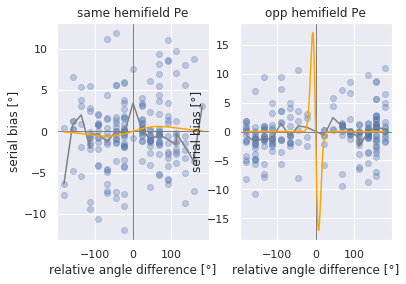

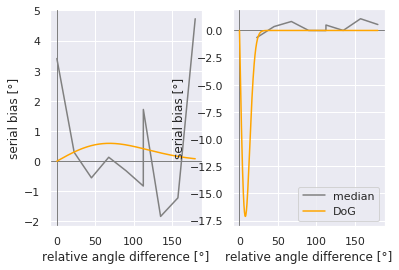

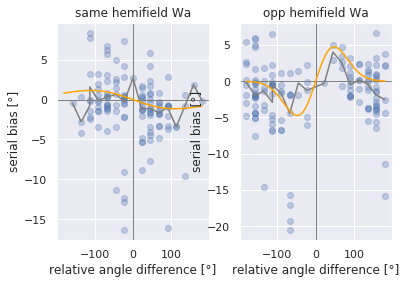

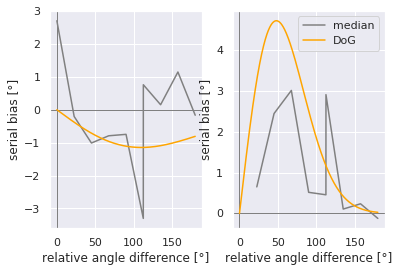

In [154]:
x_new = np.linspace(-180, 180, 1000)
x_new_onesided = np.linspace(0, 180, 500)


for m in ['Sa','Pe','Wa']:
    #num_pos = len(df_sb.loc[df_sb['monkey']==m].groupby('rel_loc')) # number of x-positions in SB curve
    #x_full = np.linspace(-180,180,num_pos)
    #x_full_onesided = np.linspace(0,180,int(num_pos/2+1))
    
    plt.figure()
    plt.subplot(121)
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    plt.scatter(df_sb_sameH.loc[df_sb_sameH['monkey']==m]['rel_loc'], df_sb_sameH.loc[df_sb_sameH['monkey']==m]['err'], alpha=0.3, label='data')
    # plots median of the values in each position
    #plt.fill_between(x_full,df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').median()['err']+df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').median()['err']-df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new, test_func(x_new, params_sameH[m][0], params_sameH[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2[0], params2[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    plt.title('same hemifield '+str(m))
    
    plt.subplot(122)
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    plt.scatter(df_sb_oppH.loc[df_sb_oppH['monkey']==m]['rel_loc'], df_sb_oppH.loc[df_sb_oppH['monkey']==m]['err'], alpha=0.3, label='data')
    # plots median of the values in each position
    #plt.fill_between(x_full,df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').median()['err']+df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').median()['err']-df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new, test_func(x_new, params_oppH[m][0], params_oppH[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2[0], params2[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    plt.title('opp hemifield '+str(m))
    #plt.legend()
    plt.show()
    #print(params)#, params2)

    
    
    # plot serial bias curve, single sided
    plt.figure()
    plt.subplot(121)
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    #plt.scatter(df_sb_onesided.loc[df_sb_onesided['monkey']==m]['rel_loc'], df_sb_onesided.loc[df_sb_onesided['monkey']==m]['err'], label='data')
    # plots median of the values in each position
    #plt.fill_between(x_full_onesided,df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').median()['err']+df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').median()['err']-df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_onesided_sameH.loc[df_sb_onesided_sameH['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_sameH[m][0], params_onesided_sameH[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    
    plt.subplot(122)
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    #plt.scatter(df_sb_onesided.loc[df_sb_onesided['monkey']==m]['rel_loc'], df_sb_onesided.loc[df_sb_onesided['monkey']==m]['err'], label='data')
    # plots median of the values in each position
    #plt.fill_between(x_full_onesided,df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').median()['err']+df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').median()['err']-df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_oppH[m][0], params_onesided_oppH[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    plt.legend()
    plt.show()
    #print(params_onesided)#, params2_onesided)
    #print('Amount of data: '+str(len(x_data_onesided[m])))

### Ttest for mirrored serial bias curve errors between same/opp hemifields, each monkey across sessions

In [155]:
for m in ['Sa', 'Pe', 'Wa']:
    print(str(m)+': difference err, same/opp hemifield: '+str(ttest_ind(df_sb_onesided_sameH.loc[df_sb_onesided_sameH['monkey']==m]['err'].values,df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m]['err'].values)))



Sa: difference err, same/opp hemifield: Ttest_indResult(statistic=2.323282856692314, pvalue=0.020284539006363855)
Pe: difference err, same/opp hemifield: Ttest_indResult(statistic=0.2698386586152965, pvalue=0.7874204725008401)
Wa: difference err, same/opp hemifield: Ttest_indResult(statistic=-2.854221370838965, pvalue=0.004660428937585807)


### compute distance from y axis

In [76]:
df_sb_sameH.head()

,rel_loc,err,delay_prev,delay_curr,target_prev,target_curr,monkey
0,44.977187,-9.477295,2130,1930,112.5,157.5,Sa
1,44.977187,-5.126253,1930,2430,157.5,202.5,Sa
2,-90.011670,10.356785,3029,1931,22.5,292.5,Sa
3,134.988857,-16.540146,1931,1830,292.5,67.5,Sa
4,-134.988857,12.323176,1830,2140,67.5,292.5,Sa


In [77]:
y_dist_prev_same=[]
y_dist_curr_same= []
y_dist_prev_opp=[]
y_dist_curr_opp= []
for n in range(len(df_sb_sameH['target_prev'])):
    if df_sb_sameH['target_prev'][n]<180:
        y_dist_prev_same.append(abs(90-df_sb_sameH['target_prev'][n]))
    else:
        y_dist_prev_same.append(abs(270-df_sb_sameH['target_prev'][n]))
        
    if df_sb_sameH['target_curr'][n]<180:
        y_dist_curr_same.append(abs(90-df_sb_sameH['target_curr'][n]))
    else:
        y_dist_curr_same.append(abs(270-df_sb_sameH['target_curr'][n]))
        
for n in range(len(df_sb_oppH['target_prev'])): 
    if df_sb_oppH['target_prev'][n]<180:
        y_dist_prev_opp.append(abs(90-df_sb_oppH['target_prev'][n]))
    else:
        y_dist_prev_opp.append(abs(270-df_sb_oppH['target_prev'][n]))
        
    if df_sb_oppH['target_curr'][n]<180:
        y_dist_curr_opp.append(abs(90-df_sb_oppH['target_curr'][n]))
    else:
        y_dist_curr_opp.append(abs(270-df_sb_oppH['target_curr'][n]))
        
df_sb_sameH['y_dist_prev'] = y_dist_prev_same
df_sb_sameH['y_dist_curr'] = y_dist_curr_same
df_sb_oppH['y_dist_prev'] = y_dist_prev_opp
df_sb_oppH['y_dist_curr'] = y_dist_curr_opp

### plot error for specific relative distance between stimuli for each hemifield over y-distance

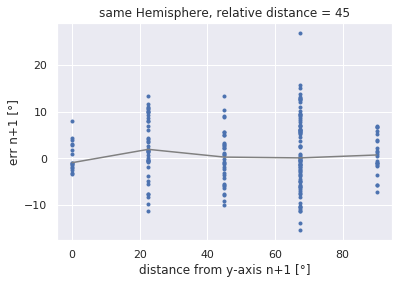

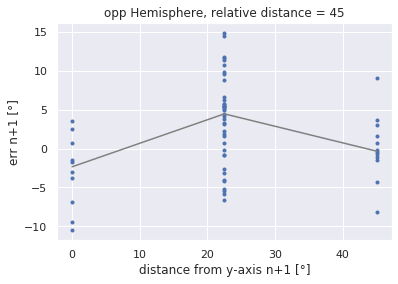

In [106]:
val = 45

plt.figure()
plt.plot(df_sb_sameH['y_dist_curr'].loc[np.where(np.round(df_sb_sameH['rel_loc']) == val)],df_sb_sameH['err'].loc[np.where(np.round(df_sb_sameH['rel_loc']) == val)], '.')
plt.plot(df_sb_sameH.loc[np.where(np.round(df_sb_sameH['rel_loc']) == val)].groupby(['y_dist_curr']).median()['err'], color='grey')
plt.xlabel('distance from y-axis n+1 [°]')
plt.ylabel('err n+1 [°]')
plt.title('same Hemisphere, relative distance = '+str(val))
plt.show()

plt.figure()
plt.plot(df_sb_oppH['y_dist_curr'].loc[np.where(np.round(df_sb_oppH['rel_loc']) == val)],df_sb_oppH['err'].loc[np.where(np.round(df_sb_oppH['rel_loc']) == val)], '.')
plt.plot(df_sb_oppH.loc[np.where(np.round(df_sb_oppH['rel_loc']) == val)].groupby(['y_dist_curr']).median()['err'], color='grey')
plt.xlabel('distance from y-axis n+1 [°]')
plt.ylabel('err n+1 [°]')
plt.title('opp Hemisphere, relative distance = '+str(val))
plt.show()


# How to deal with sparse matrices in sp_train with csr_matrix

In [ ]:
from scipy.sparse import csr_matrix

spikes = {'trial_id': [], 'spikes': [], 'delay_start':[], 'delay_end':[]}
for tr in range(0,df_dat.shape[0]):
    spikes['trial_id'].append(df_dat['trial_id'].iloc[tr])
    spikes['spikes'].append(csr_matrix(df_dat['sp_train'].iloc[tr]))#targ_on
    spikes['cue_start'].append(df_dat['targ_off'].iloc[tr])
    spikes['cue_end'].append(df_dat['targ_off'].iloc[tr])
    spikes['delay_start'].append(df_dat['targ_off'].iloc[tr])
    spikes['delay_end'].append(df_dat['go_cue'].iloc[tr])
    #print(tr)


# find longest trial -> create helper x with longest trial
#len_trial=np.zeros((len(spikes['spikes'])))
#for i in range(0, len(spikes['spikes'])):
#    len_trial[i] = spikes['spikes'][i].toarray().shape[1]
#longest_trial = np.where(len_trial == max(len_trial))[0][0]#

#trial = longest_trial # trial number to extract the spike train for
#x=csr_matrix(df_dat['sp_train'][trial])
#x=x.toarray()
#x.shape # neurons/time




array([ 208,  361,  414, ..., 4412, 4548, 4819], dtype=int32)

In [ ]:
df_dat.head()

,trial_id,sp_train,outcome,targ_xy,targ_angle,saccade_xy,saccade_angle,monkey,session,fix,targ_on,targ_off,go_cue,saccade,reward
0,1,"(40, 0)\t1.0\n (73, 0)\t1.0\n (51, 1)\t1.0...",CORRECT,"[-81.32022937758153, -196.32440065864844]",247.5,"[-94.13180712732776, -171.71289550644755]",241.268755,Sa,0,1,236,656,3706,3904,4036
1,2,"(35, 1)\t1.0\n (7, 2)\t1.0\n (12, 2)\t1.0\...",CORRECT,"[196.32440065864844, -81.32022937758153]",337.5,"[181.59180019708026, -74.49810902444511]",337.694090,Sa,0,1,239,659,2189,2391,2519
2,4,"(21, 0)\t1.0\n (68, 0)\t1.0\n (87, 0)\t1.0...",CORRECT,"[-81.32022937758157, 196.32440065864844]",112.5,"[-96.76686414165835, 177.17716528930353]",118.641548,Sa,0,1,239,659,2789,2983,3109
3,5,"(6, 0)\t1.0\n (61, 0)\t1.0\n (71, 0)\t1.0\...",CORRECT,"[-196.32440065864844, 81.3202293775816]",157.5,"[-199.06297645572684, 46.04101453015077]",166.977129,Sa,0,1,239,659,2589,2750,2879
4,6,"(79, 0)\t1.0\n (126, 0)\t1.0\n (1, 2)\t1.0...",CORRECT,"[-196.32440065864844, -81.32022937758155]",202.5,"[-206.4608640384042, -108.05421218627242]",207.625947,Sa,0,1,241,660,3090,3276,3411
